In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from sklearn.cluster import KMeans
from numpy import genfromtxt
import pandas as pd
import io
import matplotlib.pylab as pl
import ot
from scipy import linalg as la
from numpy.linalg import inv
import math
from scipy.spatial.distance import cdist
from haversine import haversine

In [3]:
#read in data
df = pd.read_csv("FixedLatLongTimeLoc.csv")
print (df.columns)
#COMPARE PERFROMANCE WITH PRACTICE DATA
'''
df = pd.read_csv("indy_ems_overdose.csv")
df.dropna(inplace = True)
df = df.drop (['id', 'date'], axis = 1)
data = df.values
print (data)
'''

C:\Users\rjhosler\Anaconda3\envs\Python3.5Test\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['Unnamed: 0', 'CALL_NO', 'UNIT_DISPATCH_DATE', 'DISPATCH_TIME',
       'CALL_TYPE_FINAL', 'CALL_TYPE_FINAL_D', 'XCOORD', 'YCOORD',
       'DATE_TIME'],
      dtype='object')


'\ndf = pd.read_csv("indy_ems_overdose.csv")\ndf.dropna(inplace = True)\ndf = df.drop ([\'id\', \'date\'], axis = 1)\ndata = df.values\nprint (data)\n'

In [70]:
x = df.drop (['CALL_NO', 'UNIT_DISPATCH_DATE', 'DISPATCH_TIME', 'CALL_TYPE_FINAL',
           'CALL_TYPE_FINAL_D', 'DATE_TIME', 'Unnamed: 0'], axis = 1)

In [62]:
d = np.stack((df.XCOORD, df.YCOORD), axis = 1)
print (d)

[[ 39.824332 -86.236119]
 [ 39.781627 -86.120826]
 [ 39.75684  -85.998714]
 ...
 [ 39.903536 -86.044623]
 [ 39.808338 -86.105886]
 [ 39.809739 -86.108618]]


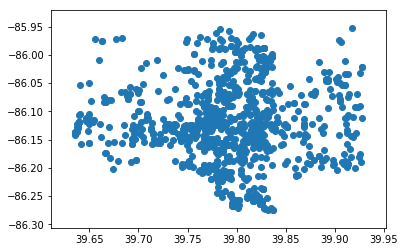

In [83]:
'''
data = np.zeros ((len (x), 2))
data [:, 0] = df.XCOORD
data [:, 1] = df.YCOORD
data = data [0:100, :]
'''
x = x.dropna()
data = x.values
data = data [0:1000, :]
plt.scatter(data[:,0], data[:,1])

In [84]:
print (np.amin((data[:,0])), np.amax((data[:,0])))
print (np.amin((data[:,1])), np.amax((data[:,1])))

39.635556 39.927606
-86.274886 -85.952546


In [85]:
#idx = np.random.choice(np.arange(len(data)), size = 30)
#X = data [idx, :]
X1 = (np.amin((data[:,0])) - np.amax((data[:,0]))) * np.random.random_sample((30,1)) + np.amax((data[:,0]))
X2 = (np.amin((data[:,1])) - np.amax((data[:,1]))) * np.random.random_sample((30,1)) + np.amax((data[:,1]))

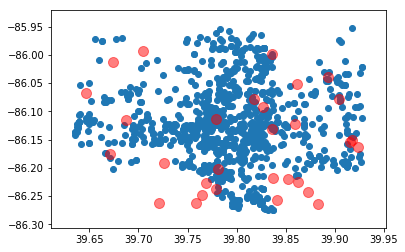

In [86]:
plt.scatter(data[:,0], data[:,1])
X = np.stack ((X1, X2), axis = 1)
X = X.reshape ((30,2))
plt.scatter(X[:, 0], X[:, 1], c = 'red', s = 100, alpha=0.5);

In [114]:
#function to implement the wasserstein algorithm
def wasserstein (M, lam, a, b, X):
    theta = 0.5
    while (1):
        M = cdist(X, data, 'euclidean')
        K = math.e ** (-1 * lam * M)
        Kt = np.divide (K, a)
        u = np.transpose (np.ones(len(X)) / len(X))
        change = 1
        while (change > 0.0001):
            oldu = u
            p = np.matmul (np.transpose (K), u)
            f = np.divide (b, p)
            g = np.matmul (Kt, f)
            u = np.transpose (np.ones(len(X)) / g)
            change = la.norm (u - oldu)
        V = np.divide (b, np.matmul (np.transpose(K), u))        
        T = np.matmul (np.matmul (np.diag(u), K), np.diag (V))
        oldX = X
        X = (X * (1 - theta)) + (np.divide (np.matmul (T, data), a) * theta)
        if (la.norm (oldX - X) < 0.004):
            return X
       

In [115]:
#assign elements in data set D to clusters in X
def cluster_assignment (D, X):
    clusters = np.zeros ((len(D), 1))
    for i in range (len(D)):
        for j in range (len(X)):
            dist = la.norm (D [i,:] - X [j,:])
            if (j == 0 or dist < minDist):
                minDist = dist
                clusters [i] = j        
    D = np.hstack ((D, clusters))
    return D
                               
    

In [116]:
#attempt to use wasserstein
M = cdist(X, data, 'euclidean')
#b = np.ones ((30)) / 30
#a = np.ones ((100)) / 100
b = 30
a = len (data)
lam = 100
test = wasserstein (M, lam, a, b, X)
fullData = cluster_assignment (data, test)

0.15248665843924658
0.08155003264898024
0.05520216018997709
0.07587785588247742
0.04955276114691983
0.04152916169857568
0.02504676101011718
0.01546122775154961
0.020912337855388482
0.04348128462566724
0.02032442645671306
0.010768811952694706
0.008644160999618027
0.007789780136487088
0.006817525221640849
0.005863252619645632
0.005146496314594152
0.004831533376506652
0.004399936466773682
0.004216603783694432
0.0039553829954574364


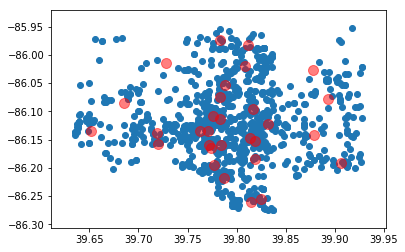

In [117]:
plt.scatter(data[:,0], data[:,1])
plt.scatter(test[:, 0], test[:, 1], c = 'red', s = 100, alpha=0.5)

In [99]:
kmeans = KMeans(n_clusters = 30, random_state = 0).fit(data)

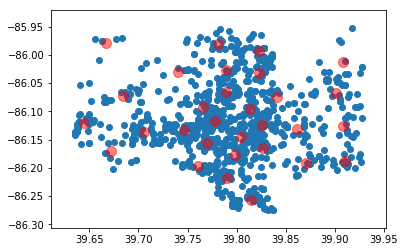

In [100]:
plt.scatter(data[:,0], data[:,1])
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 100, alpha=0.5);

In [118]:
avg_dist = np.empty([0])
for i in range (30):
    dist_array = np.empty([0])
    for j in range (len(data)):
        if (kmeans.labels_ [j] == i):
            dist_array = np.append (dist_array, haversine (kmeans.cluster_centers_ [i], data [j], miles = True))
    avg_dist = np.append (avg_dist, dist_array.mean())
print (avg_dist.mean())

0.9220876990663686


In [119]:
#fullData = cluster_assignment (data, X)
fullData = cluster_assignment (data, test)
avg_dist = np.empty([0])
for i in range (30):
    dist_array = np.empty([0])
    for j in range (len(fullData)):
        if (fullData [j,2] == i):
            dist_array = np.append (dist_array, haversine (test [i], fullData [j, 0:2], miles = True))
    avg_dist = np.append (avg_dist, dist_array.mean())
print (avg_dist.mean())

1.0833204890031072


In [120]:
#Print out overage cluster size
avg_cluster = np.empty([0])
for i in range (30):
    x = 0
    for j in range (len(data)):
        if (kmeans.labels_ [j] == i):
            x += 1
    avg_cluster = np.append (avg_cluster, x)
print (avg_cluster)
print (avg_cluster.var())
print (avg_cluster.std())

[44. 26. 15. 16. 37. 51. 23. 27. 44. 13. 28.  6. 86. 30. 31. 41. 56. 27.
 19. 30. 27. 15. 31. 65. 41. 34. 40. 26. 42. 29.]
261.1555555555555
16.160308027867398


In [121]:
#Print out overage cluster size
avg_cluster = np.empty([0])
for i in range (30):
    x = 0
    for j in range (len(data)):
        if (fullData [j,2] == i):
            x += 1
    avg_cluster = np.append (avg_cluster, x)
print (avg_cluster)
print (avg_cluster.var())
print (avg_cluster.std())

[25. 33. 25. 33. 48. 31. 11. 37. 20. 42. 36. 32. 31. 35. 38. 17. 22. 43.
 38. 29. 28. 35. 21. 37. 26. 29. 46. 40. 49. 63.]
109.75555555555555
10.476428568723005


In [165]:
print (len(data))

807
